# AI 3601 Homework 1 
## Due: 23:59:59 (GMT +08:00), March 27, 2025 ##

# Section 1. Convergence of Policy Iteration

Given an MDP with finite state space $S$, finite actions space $A$, and rewards $R(s,a,s')$. We first define the $V$-value function and $Q$-value function with reward function corresponding to state $s$, action $a$ and next state $s'$. Specifically, the $V$-value function of policy $\pi$ at state $s$ is defined as
$$
V^{\pi}(s)=\mathbb{E}\left[ \sum_{t=0}^\infty \gamma^t R(s_t,a_t, s'_t) \mid \pi,s_0=s \right],
$$

and the $Q$-value of policy $\pi$ at state $s$ and action $a$ is defined as
$$
Q^{\pi}(s,a) = \mathbb{E}\left[ \sum_{t=0}^\infty \gamma^t R(s_t,a_t, s'_t) \mid \pi,s_0=s,a_0=a \right].
$$

Corresponding to the above $V$-value and $Q$-value function, recall that the policy iteration algorithm is equivalent to
- **Policy Evaluation**: For fixed current policy $\pi_i$, compute the $V$-values by iterating until values converge:
    $$
    V_{k+1}^{\pi_i} \leftarrow \sum_{s'} P(s,\pi_i(s),s')[R(s,\pi_i(s),s')+\gamma V_k^{\pi_i}(s')],
    $$
    where $k$ denotes the iterating step when computing the values.
- **Policy Improvement**: For fixed values, get a better policy using policy extraction:
    $$
    \pi_{i+1}(s) \in \arg\max_a \sum_{s'} P(s,a,s')[R(s,a,s')+\gamma V^{\pi_i}(s')],
    $$
    which is equivalent to $\pi_{i+1}(s) \in \arg\max_a Q^{\pi_i}(s,a)$.

**Question 1.** Prove that a policy improvement step will always produce a new policy at least as good as the original one ($V^{\pi_{i+1}}(s) \geq V^{\pi_{i}}(s)$ for any state $s$), and prove that policy iteration converges to an optimal policy. You can directly provide your answer below using Markdown, or write it by hand and submit an additional PDF file in Canvas.

The solution is in **RL-HW1.pdf**.

# Section 2. Epsilon-greedy, UCB and Thompson Sampling algorithms

In this part, we will implement three algorithms in a multi-armed bandit environment.

You are required to finish  <u>*three*</u>   coding exercises and answer <u>*two*</u> questions in the following notebook.


## Environment setting -- Multi-armed bandits

Consider a finite-armed stochastic bandit problem with $K$ arms where each arm $a$ has a stationary reward distribution $R(\cdot|a)$. The expected reward of arm $a$ is defined by $Q(a)=\mathbb{E}_{r\sim R(\cdot|a)}[r]$ and the optimal arm is $~a^{∗} =argmax_{a}Q(a)$.

Each time $t$, we select one arm $a_{t}$ and obtain the reward $r_{t}\sim R(\cdot|a_t)$.

The expected regret can be defined as follows:

$$ Regret(t) = t \cdot Q(a^{∗}) - E\bigg[\sum_{i=0}^{t} r_{t}\bigg]  $$

We need to design an algorithm selecting arm to minimize the $Regret(T)$.



In [1]:
########################################

# Multi-armed bandits environment，we have three kind of settings based on the gap of mean rewards between arms 
# Here are three optional setting：

# ['small_gap','medium_gap','large_gap']

# small_gap: the gap of mean rewards between the best arms and second best arm are small. And similarly medium_gap and large_gap.

########################################

import numpy as np
from matplotlib import pyplot as plt

def set_seed(seed):
    # 试一下numpy种子是83524，random种子是43325，在policy estimation处开while True
    np.random.seed(seed)
    # np.seed(seed)

class MultiArmedBandit:
    def __init__(self, num_arms, avgs):
        self.num_arms = num_arms  # number of arms
        self.mus = avgs  # average reward of each arm
        self.sigmas = [1.0] * self.num_arms  # distribution: N sigma is deviation

    def get_reward(self, arm):
        reward = np.random.normal(
            loc=self.mus[arm],
            scale=self.sigmas[arm]
        )   # get reward from gaussain distribution N(mu,1)
        return reward

    @property
    def best_arm(self):
        return np.argmax(self.mus)

def build_mab(mab_name):
    if mab_name == "small_gap":
        return MultiArmedBandit(10, [0.6, 0.9, 0.95, 0.89, 0.8, 0.3, 0.4, 0.1, 0.85, 0.5])
    if mab_name == "medium_gap":
        return MultiArmedBandit(10, [0.6, 0.7, 0.95, 0.75, 0.7, 0.3, 0.4, 0.1, 0.65, 0.5])
    if mab_name == "large_gap":
        return MultiArmedBandit(10, [0.55, 0.35, 0.95, 0.45, 0.2, 0.3, 0.4, 0.1, 0.15, 0.5])

## In this part, we try to implement three classic algorithms：(A) epsilon-greedy, (B) UCB and (C) Thompson Sampling algorithms in the MAB environment.



In [2]:
class AbstractAlgo:
    # base of algorithm
    def __init__(self, mab):
        self.mab = mab  # multi-armed bandit
        self.num_arms = self.mab.num_arms  # number of arms

    def run(num_steps):
        raise NotImplementedError

### (A) Implement the epsilon-greedy algorithm.

At each round $t$, the agent explicitly explores a random arm with probability $ϵ$:

$$
a_{t} =
\begin{cases}
argmax_{a}\ \widehat{Q}(a), \ \ \ with \ probability \ 1 − ϵ\\
random\ arm, \ \ \ with \ probability\ ϵ
\end{cases}
$$
where $\widehat{Q}(a)$ is the sample mean of arm $a$.

**Coding exercise.** Implement the epsilon-greedy algorithm.

In [3]:

class EpsilonGreedy(AbstractAlgo):
    def __init__(self, mab, epsilon):
        super().__init__(mab)  # mab->multi-armed bandit
        self.num_pulls = np.ones(self.num_arms)  # number of pulls of each arm
        self.emp_means = np.zeros(self.num_arms)  # empirical mean reward of each arm
        self.epsilon = epsilon

    def run(self, num_steps):
        # `rewards[t]` records the received reward at round t (zero-indexed).
        # `regrets[t]` records the corresponding regret at round t (zero-indexed).
        #  Attention we will caculate cumulative_regrets via np.cumsum(regrets)
        rewards = np.zeros(num_steps)   # self.mab.mus[best_arm] * num_steps
        regrets = np.zeros(num_steps)  
        # num_steps: number of rounds

        for t in range(num_steps):
            # Stabilize the algorithm by exploring each arm once at the begining.
            if t < self.num_arms:
                arm = t  # 从0开始
                self.emp_means[arm] = self.mab.get_reward(arm)  # once pull at first

                # 补充一块代码
                # rewards[t] = self.emp_means[arm]
                # regrets[t] = self.mab.mus[self.mab.best_arm] - rewards[t]
                continue
            
            """START YOUR CODE"""
            prob = np.random.rand() # random number in [0,1]
            if prob < self.epsilon:
                # exploration
                arm = np.random.choice(self.num_arms) # random number in [0,num_arms]
            else:
                # exploitation
                arm = np.argmax(self.emp_means)
            
            rewards[t] = self.mab.get_reward(arm)
            self.num_pulls[arm] += 1
            self.emp_means[arm] = self.emp_means[arm] + 1/self.num_pulls[arm]*(rewards[t]-self.emp_means[arm]) 
            regrets[t] = self.mab.mus[self.mab.best_arm] - self.mab.mus[arm]

            """END"""

            
        # Reset.
        self.num_pulls = np.ones(self.num_arms)
        self.emp_means = np.zeros(self.num_arms)

        return rewards, regrets

### (B) Implement the upper confidence bound (UCB) algorithm. 

At each round $t$, the UCB algorithm chooses an arm based on the following equation:
$$
a_{t} = argmax_{a} (\widehat{Q}(a) + β\sqrt{\frac{2logt}{N_t(a)}})
$$

where $\widehat{Q}(a)$ is the sample mean of arm $a$, $N_t(a)$ is the visitation count of arm $a$ till round $t$,&ensp; and $β$ is a scaling factor (a hyper-parameter).

**Coding exercise.** Implement the upper confidence bound (UCB) algorithm. 

In [4]:
class UCB(AbstractAlgo):
    def __init__(self, mab, beta):
        super().__init__(mab)
        self.emp_means = np.zeros(self.num_arms)
        self.num_pulls = np.ones(self.num_arms)
        self.beta = beta

    def run(self, num_steps):
        # `rewards[t]` records the received reward at round t (zero-indexed).
        # `regrets[t]` records the corresponding regret at round t (zero-indexed).
        #  Attention we will caculate cumulative_regrets via np.cumsum(regrets)
        rewards = np.zeros(num_steps)
        regrets = np.zeros(num_steps)

        for t in range(num_steps):
            # Stabilize the algorithm by exploring each arm once at the begining.
            if t < self.num_arms:
                arm = t
                self.emp_means[arm] = self.mab.get_reward(arm)

                # 补充一块代码
                # rewards[t] = self.emp_means[arm]
                # regrets[t] = self.mab.mus[self.mab.best_arm] - rewards[t]
                continue
            
            """START YOUR CODE"""
            # argmax ( Q+beta\sqrt(slogt/Nt(a)))
            arm = np.argmax(self.emp_means+self.beta*np.sqrt(2*np.log(t)/self.num_pulls))

            rewards[t] = self.mab.get_reward(arm)
            self.num_pulls[arm] += 1
            self.emp_means[arm] = self.emp_means[arm] + 1/self.num_pulls[arm]*(rewards[t]-self.emp_means[arm]) 
            regrets[t] = self.mab.mus[self.mab.best_arm] - self.mab.mus[arm]
            
            """END"""

            
        # Reset.
        self.num_pulls = np.ones(self.num_arms)
        self.emp_means = np.zeros(self.num_arms)

        return rewards, regrets

### (C) Implement the Thompson Sampling algorithm. 

At each round $t$, the Thompson Sampling algorithm chooses an arm based on the following equation:
$$
a_{t} = argmax_{a} \widetilde{Q}_a(t),
$$

where $\widetilde{Q}_a(t) \sim Gaussian(\widehat{Q}_a(t), \frac{1}{T_a(t)+1})$, $T_a(t)$ is the visitation count of arm $a$ till round $t$, $\widehat{Q}(a)$ is the sample mean of arm $a$.

**Coding exercise.** Implement the Thompson Sampling algorithm. 


In [5]:
class ThompsonSampling(AbstractAlgo):
    def __init__(self, mab):
        super().__init__(mab)
        self.num_pulls = np.ones(self.num_arms)
        self.emp_means = np.zeros(self.num_arms)
        

    def run(self, num_steps):
        # `rewards[t]` records the received reward at round t (zero-indexed).
        # `regrets[t]` records the corresponding regret at round t (zero-indexed).
        #  Attention we will caculate cumulative_regrets via np.cumsum(regrets)
        rewards = np.zeros(num_steps)
        regrets = np.zeros(num_steps)

        for t in range(num_steps):
            # Stabilize the algorithm by exploring each arm once at the begining.
            if t < self.num_arms:
                arm = t
                self.emp_means[arm] = self.mab.get_reward(arm)

                # 补充一块代码
                # rewards[t] = self.emp_means[arm]
                # regrets[t] = self.mab.mus[self.mab.best_arm] - rewards[t]
                continue

            """START YOUR CODE"""
            arm = np.argmax(np.random.normal(self.emp_means, (1/(1+self.num_pulls))**2))

            rewards[t] = self.mab.get_reward(arm)
            self.num_pulls[arm] += 1
            self.emp_means[arm] = self.emp_means[arm] + 1/self.num_pulls[arm]*(rewards[t]-self.emp_means[arm]) 
            regrets[t] = self.mab.mus[self.mab.best_arm] - self.mab.mus[arm]
 
            """END"""
            
                        
        # Reset.
        self.num_pulls = np.ones(self.num_arms)
        self.emp_means = np.zeros(self.num_arms)

        return rewards, regrets

## Running three algorithms in the multi-armed bandits environment

Here, we try to run three algorithms in our environment. You should run the following code without editing and answer **Question 2, 3** based on the output. **Your output will be one of the criteria we use to score**.


You can also change the hyperparameters privately to get a better understanding of these three algorithms. 

In [ ]:
SEED=1
mad_name=['small_gap',"medium_gap","large_gap"] # type of bandit setting
num_iters=10000      # num of iterations
num_simulations=30   # num of simulations

set_seed(SEED)

def run_the_algorithm(mad_name,num_iters,num_simulations):

    rewards_env={}
    regrets_env={}
    
    for mad in mad_name:
        env = build_mab(mad)
        agents = {
        "UCB with beta = 1.0": UCB(env, 1.0),
        "UCB with beta = 2.0": UCB(env, 2.0),
        "UCB with beta = 3.0": UCB(env, 3.0),
        "Epsilon-greedy with epsilon = 0.1": EpsilonGreedy(env, 0.1),
        "Epsilon-greedy with epsilon = 0.2": EpsilonGreedy(env, 0.2),
        "Epsilon-greedy with epsilon = 0.3": EpsilonGreedy(env, 0.3),
        "Thompson Sampling": ThompsonSampling(env)
        }
        reward_records = {}
        regret_records = {}

        for name, agent in agents.items():
            average_rewards_all = np.zeros((num_simulations, num_iters))
            cumulative_regrets_all = np.zeros((num_simulations, num_iters))
            # for every agent, run num_simulations simulations
            for n in range(0,num_simulations):
                rewards, regrets = agent.run(num_iters)
                # calculate
                average_rewards = np.cumsum(rewards) / np.arange(1, num_iters + 1)
                cumulative_regrets = np.cumsum(regrets)
                # store
                average_rewards_all[n] = average_rewards
                cumulative_regrets_all[n] = cumulative_regrets
            # calculate ultimate result
            reward_records[name] = np.mean(average_rewards_all, axis=0)
            regret_records[name] = np.mean(cumulative_regrets_all, axis=0)
        # test 7 agents for every mab level
        rewards_env[mad]=reward_records
        regrets_env[mad]=regret_records
    
    return rewards_env,regrets_env

rewards_env,regrets_env = run_the_algorithm(mad_name,num_iters,num_simulations)

# 2m 10s



## Visualization

small_gap    UCB with beta = 1.0   regrets at t=10000   457.2276666666802
small_gap    UCB with beta = 2.0   regrets at t=10000   876.4566666665819
small_gap    UCB with beta = 3.0   regrets at t=10000   1190.915999999876
small_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   577.1216666666431
small_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   785.3109999999594
small_gap    Epsilon-greedy with epsilon = 0.3   regrets at t=10000   1140.2619999999226
small_gap    Thompson Sampling   regrets at t=10000   451.2440000000199
medium_gap    UCB with beta = 1.0   regrets at t=10000   334.6016666666659
medium_gap    UCB with beta = 2.0   regrets at t=10000   1032.4150000000157
medium_gap    UCB with beta = 3.0   regrets at t=10000   1714.2300000000057
medium_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   636.3916666666806
medium_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   851.7133333333362
medium_gap    Epsilon-greedy with ep

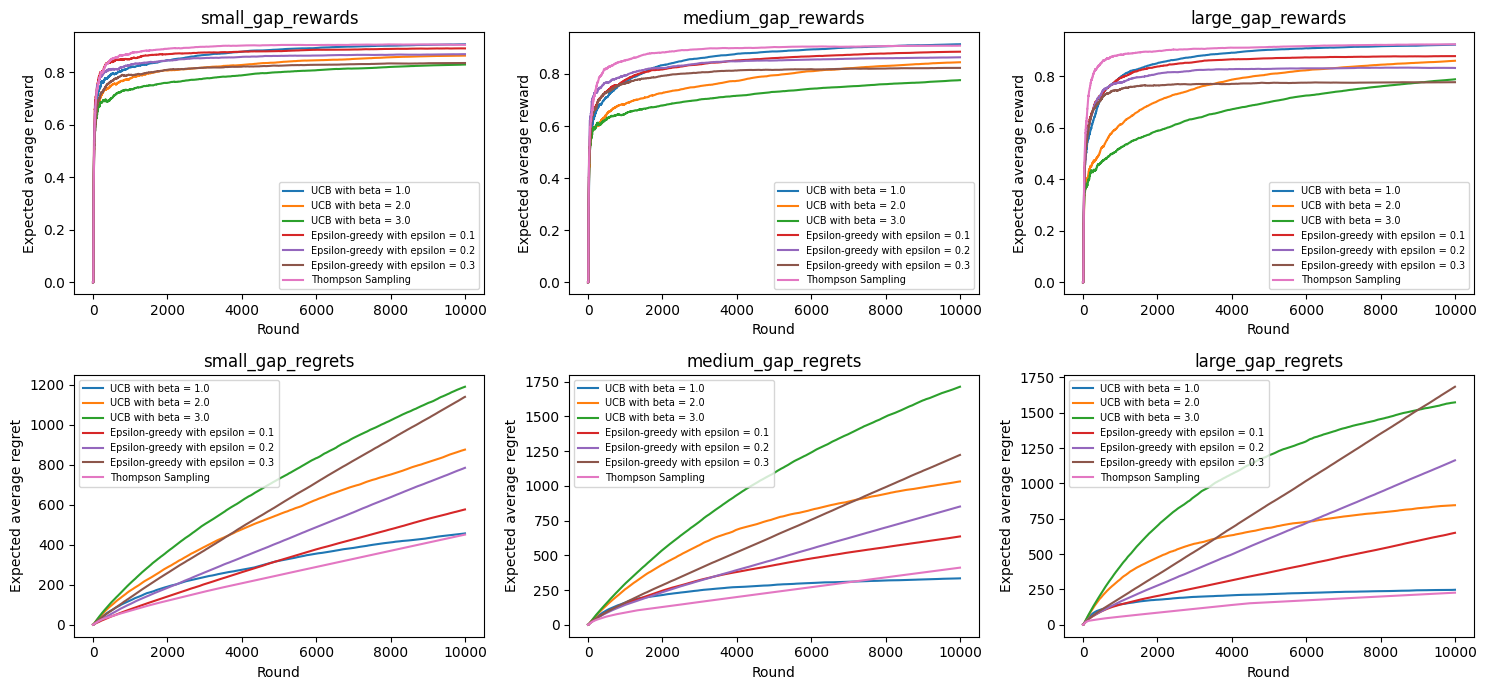

In [ ]:
x_axis = [i for i in range(0, num_iters)]
fig=plt.figure(figsize=(15,7))

for i in range(len(mad_name)):
    fig1=plt.subplot(2,3,i+1)
    plt.xlabel("Round")
    plt.ylabel("Expected average reward")
    for name, rewards in rewards_env[mad_name[i]].items():
        plt.plot(x_axis, rewards,label=name)
    plt.legend(prop={"size":7})
    plt.title(mad_name[i]+'_'+'rewards')

for i in range(len(mad_name)):
    fig1=plt.subplot(2,3,i+4)
    plt.xlabel("Round")
    plt.ylabel("Expected average regret")
    for name, regrets in regrets_env[mad_name[i]].items():
        plt.plot(x_axis, regrets,label=name)
    plt.legend(prop={"size":7})
    plt.title(mad_name[i]+'_'+'regrets')

# plt.savefig('multi_armed_bandits.png')
plt.tight_layout()

for i in range(len(mad_name)):
    for a in list(regrets_env[mad_name[i]].keys()):
        print(mad_name[i],"  ",a,"  regrets at t=10000  ",regrets_env[mad_name[i]][a][-1])

# 增加计算了初次尝试每一个拉杆时的reward和regret的结果：
# small_gap    UCB with beta = 1.0   regrets at t=10000   390.692720188341
# small_gap    UCB with beta = 2.0   regrets at t=10000   805.0995933952813
# small_gap    UCB with beta = 3.0   regrets at t=10000   1174.9690954531454
# small_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   559.6990525251065
# small_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   780.737081996751
# small_gap    Epsilon-greedy with epsilon = 0.3   regrets at t=10000   1144.5155142663184
# small_gap    Thompson Sampling   regrets at t=10000   339.2090422029952
# medium_gap    UCB with beta = 1.0   regrets at t=10000   342.7827220986376
# medium_gap    UCB with beta = 2.0   regrets at t=10000   986.155555635381
# medium_gap    UCB with beta = 3.0   regrets at t=10000   1674.9902835921996
# medium_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   647.817930105569
# medium_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   852.9683570591266
# medium_gap    Epsilon-greedy with epsilon = 0.3   regrets at t=10000   1285.5450942562202
# medium_gap    Thompson Sampling   regrets at t=10000   342.6088803633295
# large_gap    UCB with beta = 1.0   regrets at t=10000   245.4180894614529
# large_gap    UCB with beta = 2.0   regrets at t=10000   866.2848813516545
# large_gap    UCB with beta = 3.0   regrets at t=10000   1614.8872530256963
# large_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   701.3409471589506
# large_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   1137.8836131036765
# large_gap    Epsilon-greedy with epsilon = 0.3   regrets at t=10000   1725.4888690116773
# large_gap    Thompson Sampling   regrets at t=10000   226.15256817200265


# 按照原本代码的结果：
# small_gap    UCB with beta = 1.0   regrets at t=10000   386.78072861671205
# small_gap    UCB with beta = 2.0   regrets at t=10000   801.2572304494093
# small_gap    UCB with beta = 3.0   regrets at t=10000   1171.0219923862662
# small_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   556.8514712620841
# small_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   776.1585933256306
# small_gap    Epsilon-greedy with epsilon = 0.3   regrets at t=10000   1141.1540100333066
# small_gap    Thompson Sampling   regrets at t=10000   335.9301493817018
# medium_gap    UCB with beta = 1.0   regrets at t=10000   338.69080054917583
# medium_gap    UCB with beta = 2.0   regrets at t=10000   983.2469729407798
# medium_gap    UCB with beta = 3.0   regrets at t=10000   1670.117767007302
# medium_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   643.5533369605597
# medium_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   848.529695129271
# medium_gap    Epsilon-greedy with epsilon = 0.3   regrets at t=10000   1281.4769743517836
# medium_gap    Thompson Sampling   regrets at t=10000   339.7166448388037
# large_gap    UCB with beta = 1.0   regrets at t=10000   240.66669277928312
# large_gap    UCB with beta = 2.0   regrets at t=10000   861.9751983202158
# large_gap    UCB with beta = 3.0   regrets at t=10000   1610.033634777523
# large_gap    Epsilon-greedy with epsilon = 0.1   regrets at t=10000   695.6227565007106
# large_gap    Epsilon-greedy with epsilon = 0.2   regrets at t=10000   1132.4028393369751
# large_gap    Epsilon-greedy with epsilon = 0.3   regrets at t=10000   1719.9422102732904
# large_gap    Thompson Sampling   regrets at t=10000   220.20484124058493



**Questions 2.** The sub-optimality gap $\Delta=Q(a^*)-\max_{a\neq a^*}Q(a)$ is an important feature of a bandit problem. Hence, our environment prove three sub-optimality gap: small gap, medium gap and large gap. Discuss your observations on the performance of three algorithms when facing different suboptimality gaps.

- Epsilon-Greedy: In all three gap, the performance utimately improves with the decreasing of epsilon, but the gap of results is increasing from small gap to large gap. In addition, in medium gap, the performance first improves then decrease with the decreasing of epsilon at early exploration, but ultimately the best is still the model with smallest epsilon. Analyse the reason, small epsilon have less exploration, which helps for more stable results when we have known the best pull rob. However, when epsilon increase, the probability we pull the worse rob is increase, too, resulting for a worse performance. What's more, the larger gap between the optimal and suboptimal rewards means more regret from bad exploration so the gap of results also increase. 

- UCB:  In all three gap, the performance utimately improves with the decreasing of beta. From small gap to large gap, the gap of results is increasing and more precisely, large beta becomes worse and small beta becomes better. Analyse the reason: In the UCB algorithm, the confidence interval of an arm is proportional to β and inversely proportional to the number of times the arm is selected. Therefore, for a smaller β, the impact of increasing selection count is less significant. Moreover, a smaller β means we focus more on the reward value with the highest probability. In this experiment, the variance of the arm rewards is the same and relatively small, so prioritizing the highest-probability reward leads to better performance.As β increases, the focus shifts to the arm with the highest reward within the confidence interval. However, the probability of obtaining this reward may be low, which increases the likelihood of selecting the wrong arm. Additionally, as the gap between the optimal and suboptimal rewards widens, the cost of making an incorrect selection also increases, leading to a growing performance disparity.

- Thompson: This performance is the best in all three gaps. It selects the maximum value from a Gaussian distribution where the mean is the expected reward and the variance is inversely proportional to the counts of selection, which can be seen as an improvement over UCB. Analyzing the reasons, for pull rob with fewer selections, we are more tolerance toward their expected rewards, while for pull rob with more selections, we are stricter regarding their expected rewards. This aligns with the large number law in probability distributions. Thompson sampling incorporates exploration while ensuring the confidence of exploration, and since the reward variance of the pull robs is relatively small, its impact is minimal. Therefore, Thompson sampling achieves the best performance. It can be observed that UCB with β=1 eventually comes very close to this method. However, the performance of Thompson Sampling is instable through the comparison with other students' results.

**Questions 3.** What are the differences of perfermances among these three algorithms? Please briefly explain the respective advantages of each algorithm.

1. Differences of each algorithm performance: Comparing the three algorithms overall, Thompson sampling performs the best but is less stable, and its regret curve follows a "logarithmic" shape. ε-greedy comes next, and its regret curve shows a linear trend. The UCB algorithm performs the worst overall, but the best-performing of UCB is very close to Thompson sampling, and its regret curve shows "logarithmic" shape trend. The reward curves of all algorithms are similar in shape. In Q2, each result has been analyzed in detail. Explaining the shape of the regret curves, both UCB and Thompson sampling utilize the confidence regions of a Gaussian distribution. For ε-greedy, once it incorrectly identifies the optimal pull rob, there is a high probability of persistently choosing the wrong rob, leading to a regret curve growing nearly linearly.

2. Advantages of each algorithm**:
- ε-greedy: Balances exploration and exploitation, addressing the issue of insufficient initial attempts to accurately characterize the expected reward of pull robs. The degree of avoidance depends on the value of ε. What's more, using a gradually decreasing ε often yields better performance.
- UCB: Utilizes confidence intervals, allowing us to not focus on the most probable reward but on the potential maximum reward. This makes it particularly suitable for scenarios where the robs' rewards themselves have high variance.
- Thompson sampling: Can be seen as a modification of UCB, turning the UCB into a deterministic selection during each sampling step. It no longer relies on hyperparameters but only on historical experience. It inherently balances exploration and exploitation tailored to the problem, making it more convenient to use and often delivering unexpectedly good results.


# Section 3. Value-iteration and Policy-iteration


In this part, we will implement value iteration and policy iteration algorithms in a Grid World environment.

You are required to finish  <u>*two*</u>   coding exercises and answer <u>*one*</u> question in the following notebook.

## Environment setting -- Grid World

Consider a known two-dimensional grid world environment. 

You will control an agent (the robot shown in the picture) in the environment to make it to the TERMINAL STATE. Each action has a probability of 20% to not behave as expected, as
specified in $getTransitionStatesAndProbs()$. When the agent enters the TERMINAL STATE, it must take the special ‘exit’ action to get the final reward. 

Your goal is to get the maximal rewards during each episode.

![](./pic.png)

More detail about the environment is in $setting.py$.


## In this part, we try to implement two algorithms：(A) value iteration algorithm and (B) policy iteration algorithm in the Grid World environment.


In [1]:
import util
from setting import*
import numpy as np
import matplotlib.pyplot as plt
class Agent:
    """
    An agent must define a getAction method, but may also define the
    following methods which will be called if they exist:

    def registerInitialState(self, state): # inspects the starting state
    """

    def __init__(self, index=0):
        self.index = index  # agent index

    def getAction(self, state):
        util.utilraiseNotDefined()  # Method not implemented: method at line file of filename" 

### (A) Implement the value-iteration algorithm

Recall the value iteration state update equation:

$$V_{k+1}(s) \leftarrow \max_{a} \sum_{s'}P(s'|s,a)[R(s,a,s')+\gamma V_{k}(s')]$$

**Coding exercise.** Implement a value iteration agent in $ValueIterationAgent$. Your value iteration agent is an offline planner, not a reinforcement learning agent, so the relevant hyperparameter is the maximum number of iterations of value iteration it should run in its initial planning phase.

You are also required to enable early stopping for value iteration by checking whether the maximum change of values among the states is smaller than hyperparameter $ϵ$  in an iteration.

Implement the following methods for $ValueIterationAgent$.

• Method $runValueIteration$ computes the value function $self.values$ by running the value iteration algorithm.

• Method $computeActionfromvalues(state)$ computes the best action according to the valuefunction given by $self.values$.

• Method $computeQvalueFromvalues(state, action)$ returns the Q-value of the $(state, action)$ pair given by the value function self.values.

In [18]:


class ValueIterationAgent(Agent):
    """An agent that takes a Markov decision process on initialization
    and runs value iteration for a given number of iterations.

    Hint: Test your code with commands like `python main.py -a value -i 100 -k 10`.
    """
    def __init__(self, mdp, discount = 0.9, epsilon=0.001, iterations = 100):
        """
          Your value iteration agent should take an mdp on
          construction, run the indicated number of iterations
          and then act according to the resulting policy.

          Some useful mdp methods you will use:
              mdp.getStates()
              mdp.getPossibleActions(state)
              mdp.getTransitionStatesAndProbs(state, action)
              mdp.getReward(state, action, nextState)
              mdp.isTerminal(state)
        """
        self.mdp = mdp
        self.discount = discount
        self.epsilon = epsilon  # For examing the convergence of value iteration
        self.iterations = iterations # The value iteration will run AT MOST these steps
        self.values = util.Counter() # You need to keep the record of all state values here
        self.runValueIteration()

    def runValueIteration(self):
        """ YOUR CODE HERE """
        # compute self.value in this iteration(exploration)
        # value = max \sum_{s'} T(s,a,s')[R(s,a,s')+discount*V(s')] = max Q(s,a)
          
        for i in range(self.iterations):
            values = util.Counter()
            for state in self.mdp.getStates():
                # no next state
                # if self.mdp.isTerminal(state):
                    # continue  # 对于终点应该会直接给出0,action为()不会进入循环
                qvalues = []
                for action in self.mdp.getPossibleActions(state):
                    qsa = self.computeQValueFromValues(state, action)
                    qvalues.append(qsa)
                values[state] = max(qvalues) if qvalues else 0  # 解决终点问题
            delta = [values[key] - self.values[key] for key in values.keys()]
            self.values = values.copy()  # 保存更新完的，只是更新的比较少
            if np.max(delta) < self.epsilon:
                break
            
        
        """ END CODE HERE """
        return

    def getValue(self, state):
        """Return the value of the state (computed in __init__)."""
        return self.values[state]

    def computeQValueFromValues(self, state, action):
        """Compute the Q-value of action in state from the value function stored in self.values."""
        """ YOUR CODE HERE """
        value=0
        # 给定action计算Q(s,a)=\sum_{s'} T(s,a,s')[R(s,a,s')+discount*V(s')]
        for nextState, prob in self.mdp.getTransitionStatesAndProbs(state, action):
            value+=prob*(self.mdp.getReward(state, action, nextState)+self.discount*self.values[nextState])
        """ END CODE HERE """
        return value

    def computeActionFromValues(self, state):
        # argmax value
        """The policy is the best action in the given state
        according to the values currently stored in self.values.

        You may break ties any way you see fit.  Note that if
        there are no legal actions, which is the case at the
        terminal state, you should return None.
        """
        """ YOUR CODE HERE """
        # 所有可选的action中，选择Q(s,a)最大的action
        actions = self.mdp.getPossibleActions(state)
        maxreward = None
        bestaction = None
        for action in actions:
            reward = self.computeQValueFromValues(state, action)
            if maxreward is None or reward > maxreward:
                maxreward = reward
                bestaction = action
       
        """ END CODE HERE """
        return bestaction

    def getPolicy(self, state):
        return self.computeActionFromValues(state)

    def getAction(self, state):
        return self.computeActionFromValues(state)

    def getQValue(self, state, action):
        return self.computeQValueFromValues(state, action)


### (B) Implement the policy iteration algorithm.

Let us recall the policy iteration algorithm as the first step. Given an MDP with a finite state space, action space, and reward function $R(s,a, s^{\prime})$. We first define the $V$-value function and $Q$-value function with reward function corresponding to state $s$, action $a$ and next state $s^{\prime}$. Specifically, the $V$-value of policy $\pi$ at state $s$ is defined as
 $$
     V^\pi(s)=\mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t R\left(s_t, a_t, s_t^{\prime}\right) \mid \pi, s_0=s\right]\,,
 $$
 and the $Q$-value of policy $\pi$ at state $s$ and action $a$ is defined as
 $$
     Q^\pi(s, a)=\mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t R\left(s_t, a_t, s_t^{\prime}\right) \mid \pi, s_0=s, a_0=a\right]\,.
 $$
Corresponding to the above $V$-value and $Q$-value function, recall that the policy iteration algorithm is equivalent to

• **Policy Evaluation:** For fixed current policy $\pi_i$,
    compute the $V$ values by iterating until values converge:
           $$
               V_{k+1}^{\pi_i}(s) \leftarrow \sum_{s^{\prime}} P\left(s, \pi_i(s), s^{\prime}\right)\left[R\left(s, \pi_i(s), s^{\prime}\right)+\gamma V_k^{\pi_i}\left(s^{\prime}\right)\right]\,,
           $$
           where $k$ denotes the iterating step when computing the values. 

• **Policy Improvement:** For fixed values, get a better policy using policy extraction:
           $$
                \pi_{i+1}(s)\in \arg \max _a \sum_{s^{\prime}} P\left(s, a, s^{\prime}\right)\left[R\left(s, a, s^{\prime}\right)+\gamma V^{\pi_i}\left(s^{\prime}\right)\right] 
           $$
           which is equivalent to $\pi_{i+1}(s)\in \arg \max _a Q^{\pi_i}(s,a)$.

**Coding exercise.** Implement a policy iteration agent in $PolicyIterationAgent$. 

Again, your policy iteration agent is an offline planner and the relevant hyperparameter is the maximum number of iterations of policy iteration, which is determined by hyperparameter iteration. Policy evaluation iterates until
values converge, which is also determined by hyperparameter $ϵ$.

If the policy does not change in the policy improvement phase, policy iteration stops early.


In [19]:
import random
class PolicyIterationAgent(Agent):
    """An agent that takes a Markov decision process on initialization
    and runs policy iteration for a given number of iterations..
    """

    def __init__(self, mdp, discount = 0.9, epsilon=0.001, iterations = 100):
        self.mdp = mdp
        self.discount = discount
        self.epsilon = epsilon  # For examing the convergence of policy iteration
        self.iterations = iterations # The policy iteration will run AT MOST these steps
        self.values = util.Counter() # You need to keep the record of all state values here
        self.policy = dict()
        self.runPolicyIteration()

    def runPolicyIteration(self):
        """ YOUR CODE HERE """
        # 首先对Policy进行随机初始化
        for state in self.mdp.getStates():
            if self.mdp.isTerminal(state):
                continue  # 没有可选择的动作
            self.policy[state] = random.choice(self.mdp.getPossibleActions(state))
            
        for i in range(self.iterations):
            # policy evaluation
            while True:
                # value的初始化为0
                values = util.Counter()  
                for state in self.mdp.getStates():
                    if self.mdp.isTerminal(state):
                        values[state] = 0
                        continue   # 为防止没有action的问题，直接解决，在设置中所有terminal都是0，没有任何可选动作和下一状态，None不能算在()里
                    action = self.policy[state]  # 获取确定性策略的action
                    values[state] = self.computeQValueFromValues(state, action)  # Q(s,a)

                delta = [values[key] - self.values[key] for key in values.keys()]
                self.values = values.copy()
                if np.max(delta) < self.epsilon:
                    break
                
            # policy improvement
            policy = dict()
            for state in self.mdp.getStates():
                policy[state] = self.computeActionFromValues(state)  # action只能是Possible里面的
                # print(state, policy[state])
            if self.policy == policy:
                break
            self.policy = policy.copy()  # 如果不相等，更新，如果相等，没有更新的意义，可以放到后面 

        """END"""
        return

    def getValue(self, state):
        """Return the value of the state (computed in __init__)."""
        return self.values[state]

    def computeQValueFromValues(self, state, action):
        """Compute the Q-value of action in state from the value function stored in self.values."""
        
        """ YOUR CODE HERE """
        value = 0
        # print(state,action)
        for nextState, prob in self.mdp.getTransitionStatesAndProbs(state, action):
            value += prob*(self.mdp.getReward(state, action, nextState)+self.discount*self.values[nextState])  
        """END"""
        return value

    def computeActionFromValues(self, state):
        """The policy is the best action in the given state
          according to the values currently stored in self.values.

          You may break ties any way you see fit.  Note that if
          there are no legal actions, which is the case at the
          terminal state, you should return None.
        """

        """ YOUR CODE HERE """
        bestaction=None
        actions = self.mdp.getPossibleActions(state)  # four directions/ exits
        # print(state, actions)
        maxqsa = None
        # 开始的时候几个状态都是0，所以这里不能为0，随着迭代周围的环境改变了，他才会变。policy_evaluation只会改变那些已经正确选择到的状态的value
        # -1也不行，因为reward有负的
        for action in actions:
            qsa = self.computeQValueFromValues(state, action)
            # print(state,action,qsa)
            if maxqsa is None or qsa > maxqsa:
                maxqsa = qsa
                bestaction = action        
                
        """END"""
        return bestaction

    def getPolicy(self, state):
        return self.policy[state]

    def getAction(self, state):
        return self.policy[state]

    def getQValue(self, state, action):
        return self.computeQValueFromValues(state, action)

## Running two algorithms in the GRID-WORLD environment and  Visualization

Here, we try to run two algorithms in our environment. You should run the following code without editing and answer **Questions 4** based on the output. **Your output will be one of the criteria we use to score**.


You also can change the hyperparameters privately to get a better understanding of these two algorithms. 




RUNNING 50 EPISODES
AGENT policy
ITERS : 1  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.11221275240521404




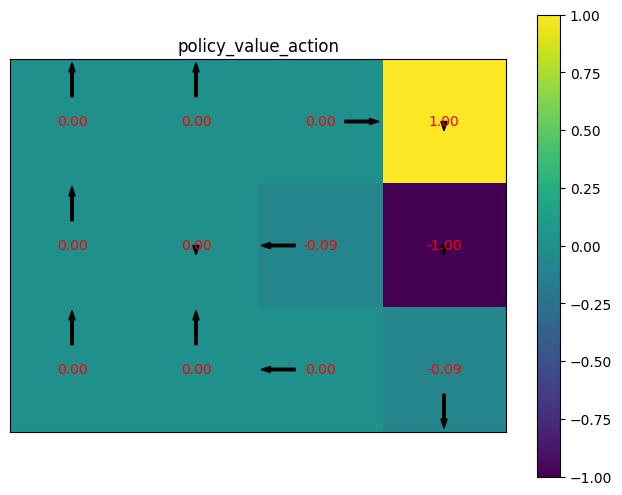


RUNNING 50 EPISODES
AGENT value
ITERS : 1  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.10544309773879174




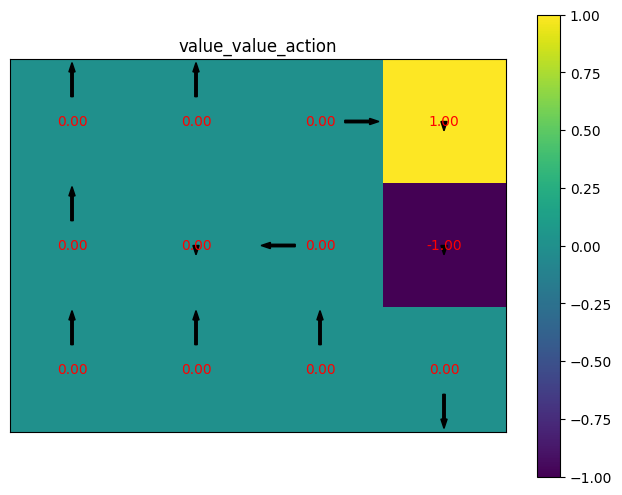


RUNNING 50 EPISODES
AGENT policy
ITERS : 2  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.5090843756644304




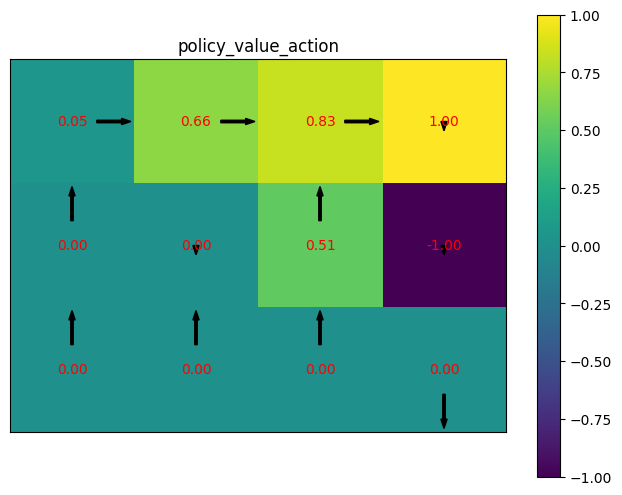


RUNNING 50 EPISODES
AGENT value
ITERS : 2  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.30424842807116514




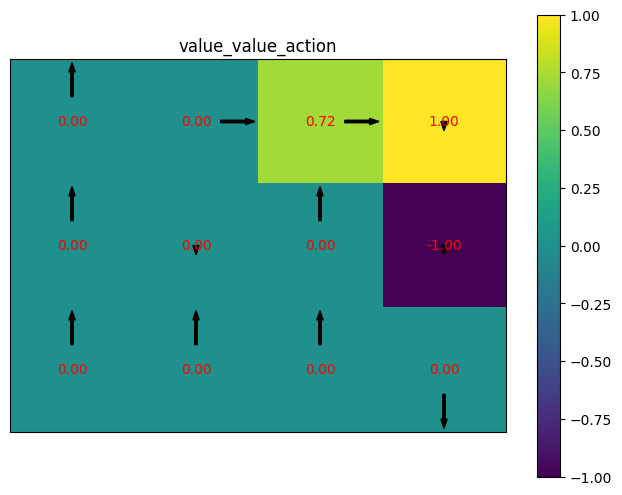


RUNNING 50 EPISODES
AGENT policy
ITERS : 3  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.48721923932940014




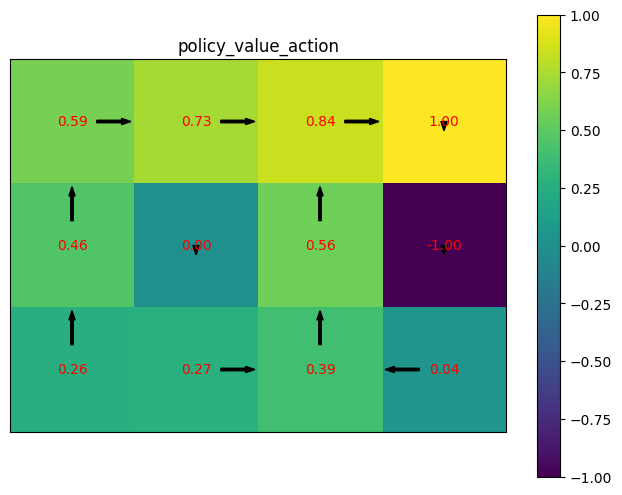


RUNNING 50 EPISODES
AGENT value
ITERS : 3  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.49917777663005986




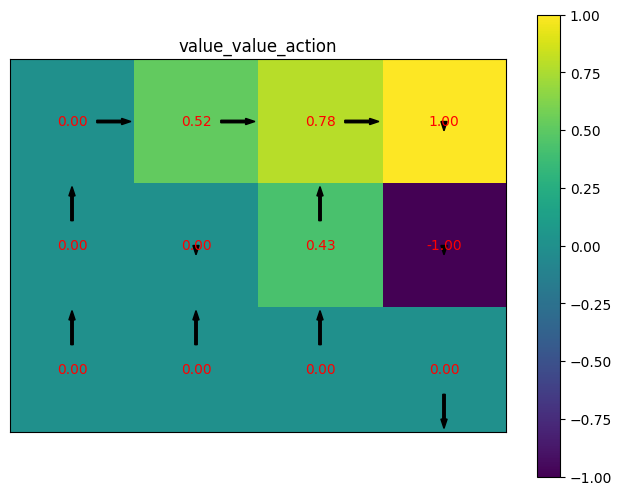


RUNNING 50 EPISODES
AGENT policy
ITERS : 4  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.47407569694200014




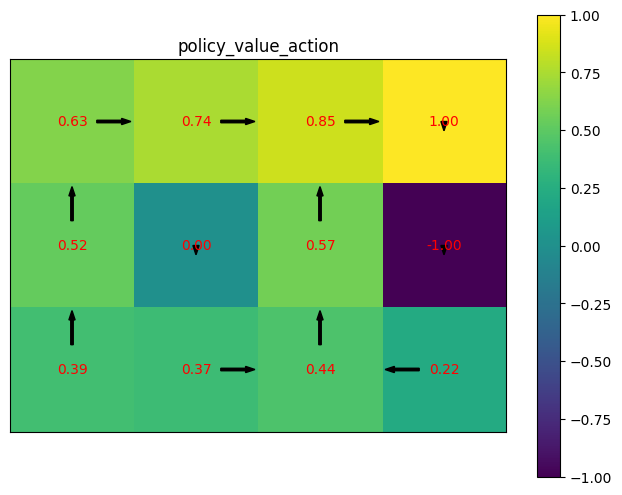


RUNNING 50 EPISODES
AGENT value
ITERS : 4  ,AVERAGE SUM OF REWARDS FROM START STATE: 0.4627614375934202




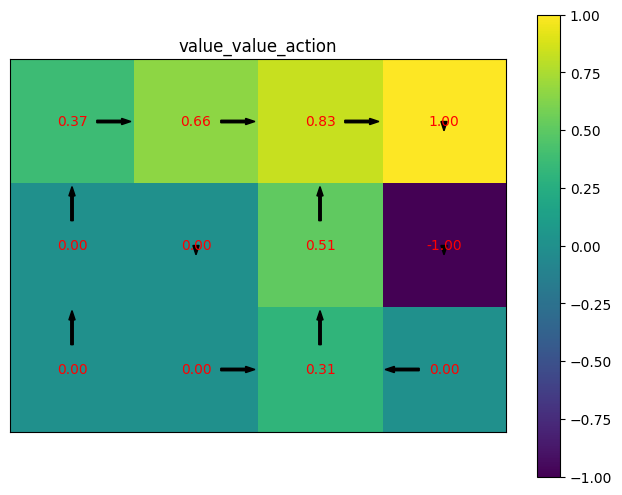

In [20]:
#####hyperparameters#########
np.random.seed(0)
grid="BookGrid"            #type of environment,"BridgeGrid"#"BookGrid"
epsilon=0.3      
agents=["policy","value"]  #optional policy ,value
iters_list=[1,2,3,4]       # num of iterations
discount=0.9
episodes=50

###############################




def runEpisode(agent, environment, discount, decision, message, pause, episode):
    returns = 0
    totalDiscount = 1.0
    environment.reset()
    if 'startEpisode' in dir(agent): agent.startEpisode()
    message("BEGINNING EPISODE: "+str(episode)+"\n")
    while True:

        # DISPLAY CURRENT STATE
        state = environment.getCurrentState()
        # display(state)
        pause()

        # END IF IN A TERMINAL STATE
        actions = environment.getPossibleActions(state)
        if len(actions) == 0:
            message("EPISODE "+str(episode)+" COMPLETE: RETURN WAS "+str(returns)+"\n")
            return returns

        # GET ACTION (USUALLY FROM AGENT)
        action = decision(state)
        if action == None:
            raise 'Error: Agent returned None action'

        # EXECUTE ACTION
        nextState, reward = environment.doAction(action)
        message("Started in state: "+str(state)+
                "\nTook action: "+str(action)+
                "\nEnded in state: "+str(nextState)+
                "\nGot reward: "+str(reward)+"\n")
        # UPDATE LEARNER
        if 'observeTransition' in dir(agent):
            agent.observeTransition(state, action, nextState, reward)

        returns += reward * totalDiscount
        totalDiscount *= discount

    if 'stopEpisode' in dir(agent):
        agent.stopEpisode()



# opts = parseOptions()

###########################
# GET THE GRIDWORLD
###########################

mdpFunction = eval("get"+grid)
mdp = mdpFunction()
env = GridworldEnvironment(mdp)

###########################
# GET THE DISPLAY ADAPTER
###########################


def get_values_actions(a,num):
    width=0
    heigh=0
    for i in range(len(list(a.values.keys()))):
        if(len(list(a.values.keys())[i])==2):
            if(width<list(a.values.keys())[i][0]+1):
                width=list(a.values.keys())[i][0]+1
            if(heigh<list(a.values.keys())[i][1]+1):
                heigh=list(a.values.keys())[i][1]+1
    # width=list(a.values.keys())[-1][0]+1
    # heigh=list(a.values.keys())[-1][1]+1
    vi=np.zeros((heigh,width))
    action_x=np.zeros((heigh,width))
    action_y=np.zeros((heigh,width))
    # print(heigh,width)
    for i in range(width):
        for j in range(heigh):
            
            vi[heigh-1-j][i]=a.values[(i,j)]
            if((i,j) not in a.policy ):
                continue
            if(a.policy[(i,j)]=="east"):
                action_x[heigh-1-j][i]=num
                action_y[heigh-1-j][i]=0
            elif(a.policy[(i,j)]=="south"):
                action_x[heigh-1-j][i]=0
                action_y[heigh-1-j][i]=num
            elif(a.policy[(i,j)]=="west"):
                action_x[heigh-1-j][i]=-num
                action_y[heigh-1-j][i]=0   
            elif(a.policy[(i,j)]=="north"):
                action_x[heigh-1-j][i]=0
                action_y[heigh-1-j][i]=-num
    return vi,action_x,action_y

def plot_(value_mat,action_x,action_y,agent_type,env_name):
    if(env_name=="BookGrid"):
        vmin=-1
        vmax=1
    elif(env_name=="BridgeGrid"):
        vmin=-100
        vmax=10
    matrix = value_mat

    plt.figure(figsize=(value_mat.shape[1]*2,value_mat.shape[0]*2))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest',vmin=vmin, vmax=vmax)

    for i in range(value_mat.shape[0]):
        for j in range(value_mat.shape[1]):
            plt.text(j , i , '{:.2f}'.format(matrix[i, j]), ha='center', va='center', color='red')
            plt.arrow(j+action_x[i][j] , i+action_y[i][j] , action_x[i][j], action_y[i][j], color='black', width=0.02, head_width=0.05)
    plt.title(agent_type+"_value_action")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.savefig(agent_type+"_"+env_name+"_value_action.png")
    plt.show()


###########################
# RUN EPISODES
###########################

messageCallback = lambda x: printString(x)
messageCallback= lambda x : None 
# FIGURE OUT WHETHER TO WAIT FOR A KEY PRESS AFTER EACH TIME STEP
pauseCallback = lambda : None
# RUN EPISODES


sum_of_rewards_value=[]
sum_of_rewards_policy=[]

for iters in iters_list:
    for agent in agents:
        a = None
        if agent == 'value':
            a = ValueIterationAgent(mdp, discount, epsilon, iters)

        elif agent == 'policy':
            a = PolicyIterationAgent(mdp, discount, epsilon,iters)
        else:
            raise Exception('Unknown agent type: '+agent)
        
        decisionCallback = a.getAction

        if episodes > 0:
            print()
            print("RUNNING", episodes, "EPISODES")
            print("AGENT",agent)
        returns = 0
        for episode in range(1, episodes+1):
            returns+= runEpisode(a, env, discount, decisionCallback, messageCallback, pauseCallback, episode)
        if episodes > 0:
            # print()
            print("ITERS : "+str(iters)+"  ,AVERAGE SUM OF REWARDS FROM START STATE: "+str((returns+0.0) / episodes))
            print()
            print()
        if(agent=="value"):
            sum_of_rewards_value.append((returns+0.0) / episodes)
            a.policy={}
            for key in list(a.values.keys()):
                a.policy[key]=a.getPolicy(key)
        else:
            sum_of_rewards_policy.append((returns+0.0) / episodes)
        
        # if(iters==iters_list[-1]):
        value_mat,action_x,action_y=get_values_actions(a,0.2)
        plot_(value_mat,action_x,action_y,agent,grid)


**Questions 4.**

Observe the pictures of all states against the number of iterations for both $ValueIterationAgent$ and $PolicyIterationAgent$. 

Which algorithm converges faster?   (Which algorithm converges to optimal policy faster?) 

Explain your conclusion.

**Answer**

Both methods undergo four iterations, and it is evident that Policy Iteration converges faster. Analyzing the reasons, policy convergence is faster than value convergence. When value evaluation iterates to a certain extent but has not yet converged, its corresponding greedy policy may have already converged.

Value iteration focuses on computing the converged state value for the environment. In each value iteration, it performs one time state value update, and finally, it derives the policy through a greedy algorithm, achieving convergence in value. On the other hand, policy iteration learns the policy directly. In each policy iteration, it first evaluates the current policy (by computing the state value) and then updates the policy using a greedy approach. This means that each iteration in policy iteration involves a larger extent update, leading to policy convergence.

In summary, although policy iteration often requires more computational effort in each iteration, it converges faster compared to value iteration.